# Interior Point Method
Large scale 에서 non-linear programing 방법으로 많이 사용되는 Ipopt(Interior point optimization) 혹은 barrier method라고 불리는 방법 에 대해서 알아보자.

## Overview
nonlinear constraint optimization을 풀기 위해서 equality constraint에 log barrrier function을 도입하여 lagrange dual problem으로 바꾸는 과정을 알아본다.   
이후 Ipopt pseudo code를 보고 구현해서 예제를 구현해보자.  

In [1]:
import numpy as np
np.set_printoptions(precision=2, suppress=True)
from matplotlib import pyplot as plt
from copy import deepcopy
import matplotlib.cm as cm
from mpl_toolkits import mplot3d
import warnings
# warnings.filterwarnings(action='ignore') 
import pdb
%matplotlib inline

## Constraint Minimization
$$
\underset{x}{min}f_{0}(x) \\
s.t \;\; f_{i}(x) \leq 0 \;\;,i=1,\dots,m \\
Ax = b
$$
우선 optimization을 위의 형식으로 바꾸어야 되는 과정이 필요하다.

## Logarithmic barrier function
$$
 \phi(x) = - \sum_{i=1}^{m} \log (- f_{i}(x)) \;\; ,dom \;\phi = \{ x | f_{i} (x) < 0, \;\; i=1,\dots,m \}
$$

In [2]:
def barrier(f, x, max_penelty=1000):
    '''
    f: m dimensional function call instance
    x: n dimensional variables
    '''    
    penalty = -np.sum(np.log(-f(x)), axis=0)
#     penalty[np.isnan(penalty)] = max_penelty
    return penalty

/home/swyoo/anaconda3/envs/cvxpy/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log
  
/home/swyoo/anaconda3/envs/cvxpy/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log
  
/home/swyoo/anaconda3/envs/cvxpy/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log
  
/home/swyoo/anaconda3/envs/cvxpy/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log
  


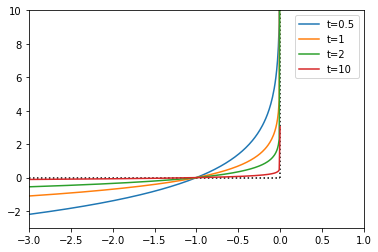

In [3]:
from numpy import errstate

for t in [0.5, 1, 2, 10]:    
    plt.plot(np.arange(-3, 1, 0.01), (1/t)*barrier(lambda x: np.array([x]), np.arange(-3, 1, 0.01)), label='t={}'.format(t))
plt.gca().set_xlim(-3,1)
plt.gca().set_ylim(-3,10)
plt.hlines(y=0, xmin=-3, xmax=0, linestyles='dotted', color = 'k')
plt.vlines(x=0, ymin=0, ymax=10, linestyles='dotted', color = 'k')
plt.legend()

$f(x)=x$ 일경우 위의 예제를 보면 t 가 증가할수록 이상적인 penalty function과 가까워진다는 것을 알수 있다.  
barrier function을 사용하면 standard Constraint Minimization 문제를 다음과 같이 inequality constraint를 penalty로 더하여 표현할 수 있다.

$$
\underset{x}{min} \; f_{0}(x) - \frac{1}{t}\sum_{i=1}^{m} \log (- f_{i}(x)) \\
s.t \;\; Ax = b
$$

간단한 예제를 통해서 penalty가 추가되므로써 objective 가 어떻게 바뀌는지 알아보자.
$$
\underset{x \in \mathbb{R}}{min} \; (x+1)^2 \;\;s.t. \; x \geq 0
$$
standard constraint minimization 형태로 바꿀 수 있고 아래와 같다.
$$
\underset{x \in \mathbb{R}}{min} \; (x+1)^2 \;\;s.t. \; -x \leq 0
$$
이때 objective와 constraint 함수는 아래와 같다.
$$
f_{0}(x) = (x+1)^2 \\
f_{1}(x) = -x 
$$
log-barrier penalty를 더하여 unconstraint optimization으로 바꾸면 아래와 같다.
$$
\underset{x \in \mathbb{R}}{min} \; (x+1)^2 - \frac{1}{t} \ln x
$$

/home/swyoo/anaconda3/envs/cvxpy/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log
  
/home/swyoo/anaconda3/envs/cvxpy/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log
  
/home/swyoo/anaconda3/envs/cvxpy/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log
  
/home/swyoo/anaconda3/envs/cvxpy/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log
  


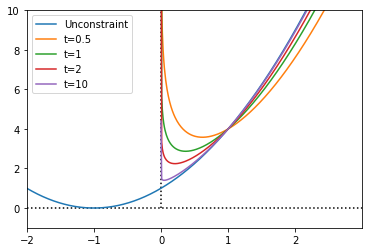

In [4]:
f0 = lambda x: (x+1)**2
f1 = lambda x: np.array([-x])

x = np.arange(-2, 3, 0.01)
plt.plot(x, f0(x), label='Unconstraint')
for t in [0.5, 1, 2, 10]:
    plt.plot(x, f0(x) + (1/t)*barrier(f1, x), label='t={}'.format(t))
    
plt.gca().set_xlim(x.min(),x.max())
plt.gca().set_ylim(-1,10)
plt.hlines(y=0, xmin=x.min(), xmax=x.max(), linestyles='dotted', color = 'k')
plt.vlines(x=0, ymin=0, ymax=10, linestyles='dotted', color = 'k')
plt.legend()


t 가 커질 수록 constraint가 강화되어서 feasible boundary쪽으로 optimal optimal point가 이동하는 것을 볼수있다.  
다음과 같이 t에 따라 변하는 optimal point들의 집합을 central path라고 한다.   
$$
\{x^{*}(t)| t > 0\}
$$
central path는 $f_{0}(x)$의 level curve를 따라서 이동한다.  

## Dual points on central path

모든 central point들은 그에 대응하는 dual feasible point들을 갖는다. 이때 duality gap이 t에 따라서 어떻게 달라지는 지 알아보자.  
그것을 통해서 dual feasible point가 얼마만큼 sub-optimal한 값인지 알아보자.  
  
central path $t > 0$ 에서 다음과 같은 문제의 해집합이다.
$$
\begin{align}
    \underset{x}{min} &\; f_{0}(x) - \frac{1}{t}\phi(x) \\
    &s.t \;\; Ax = b \\
    &,where  \; \phi(x) = - \sum_{i=1}^{m} \log (- f_{i}(x)) \;\; ,dom \;\phi = \{ x | f_{i} (x) < 0, \;\; i=1,\dots,m \}
\end{align}
$$
  
위문제를 Lagrange dual prblem으로 바꾸기 위해서 KKT 조건 중 stationary condition에 의하면 다음과 같은 관계가 성립한다.

$$
\begin{align}
    \nabla_{x} L(x, \nu^{*}) &= \nabla_{x} f_{0}(x) - \frac{1}{t} \nabla_{x} \phi(x) + \nabla (Ax-b)^{T}\nu^{*} \\
    &= \nabla_{x} f_{0}(x) - \sum_{i=1}^{m} \frac{1}{t f_{i} (x)} \nabla_{x} f_{i} (x) + A^{T} \nu^{*} \\
    \nabla_{x} \big[L(x, \nu^{*})\big]|_{x=x^{*}} &=  \nabla_{x} f_{0}(x^{*}) - \sum_{i=1}^{m} \frac{1}{t f_{i} (x^{*})} \nabla_{x} f_{i} (x^{*}) + A^{T} \nu^{*} = 0
\end{align}
$$

위의 식을 다시 matrix form으로 정리하면 다음과 같다.
$$
\begin{align}
\nabla_{x} f_{0}(x^{*}) + \nabla_{x} \lambda^{*}(t)^{T} F^{*} + A^{T} \nu^{*} &= 0 \\
\;\;,where \;F^{*} &= (f_{1}(x^{*}), \dots, f_{m}(x^{*})) \\
\lambda^{*}(t) &= (\lambda_{1}^{*}(t), \dots, \lambda_{m}^{*}(t)) ,\; \lambda_{i}^{*}(t) = \frac{1}{t f_{i} (x^{*})} 
\end{align}
$$ 

따라서 Lagrange funtion은 다음과 같다.  

$$
L(x, \lambda, \nu) = f_{0}(x) + \lambda(t)^{T} F + \nu^{T}(Ax-b)
$$

기존 Lagrange funtion과 다른점은 complementary slackness가 다음과 같이 근사된다는 점이다.
$$
\lambda_{i} f_{i}(x) = 0 \rightarrow -\lambda_{i}(t) f_{i}(x) = \frac{1}{t} ,\; \forall i
$$

이어서 Lagrange funtion 을 통해 구한 해가 얼마만큼 sub-optimal한 지를 살펴보자.   
feasible 조건을 이용하면 아래와 같이 유도된다.  
$$
\begin{align}
p^{*} &\geq \underset{\lambda, \nu}{sup}\; L(x^{*}(t), \lambda(t), \nu) \\
&= f_{0}(x^{*}) - \sum_{i=1}^{m} \frac{1}{t f_{i} (x^{*})} f_{i} (x^{*}) + (Ax^{*}-b)^{T}\nu \\
&= f_{0}(x^{*}) - \frac{m}{t}
\end{align}
$$
따라서 Ipopt 방법은 $\frac{m}{t} suboptimal$ 알고리즘이다.

# Example
예제를 통해 다음과 같은 문제를 풀어보자
$$
\begin{align}
\underset{x\in \mathbb{R}^{2}}{min}\;& x_{2}(5 + x_{1}) \\
s.t. &\;\; x_1 x_2 \geq 5 \\
&x_{1}^{2} + x_{2}^{2} \leq 20
\end{align}
$$
위의 식을 standard constraint minimization 식으로 바꾸면 다음과 같다.
$$
\begin{align}
\underset{x\in \mathbb{R}^{2}}{min}\;& x_{2}(5 + x_{1}) \\
s.t. &\;\; 5-x_1 x_2 \leq 0 \\
&x_{1}^{2} + x_{2}^{2}-20 \leq 0
\end{align}
$$
그러면 objective와 inequality constraint 는 다음과 같이 unconstraint optmization식으로 된다.
$$
\begin{align}
\underset{x}{min} &\; f_{0}(x) - \frac{1}{t}\sum_{i=1}^{2} \log (- f_{i}(x)) \\
f_{0}(x) &=  x_{2}(5 + x_{1})\\
f_{1}(x) &=  5-x_1 x_2\\
f_{2}(x) &=  x_{1}^{2} + x_{2}^{2}-20\\
\end{align}
$$

/home/swyoo/anaconda3/envs/cvxpy/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log
  


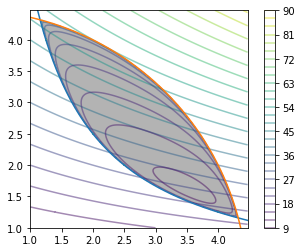

In [5]:
def f(x):
    return x[1]*(5+x[0])
def g(x):    
    return (x[0]*x[1] >= 5) & (x[0]**2 + x[1]**2 <= 20)
def k(x):
    y1 = 5/x    
    y2 = np.sqrt(20 - (x**2))
    return np.array([y1,y2])
def constr(x):    
    f1 = 5 - x[0]*x[1]  
    f2 = x[0]**2 + x[1]**2 - 20
    return np.array([f1,f2])

# plt.rcParams["figure.figsize"] = (5,5)
x = np.arange(1,np.sqrt(20),0.01)
plt.xlim(x.min(),x.max())
plt.ylim(x.min(),x.max())
plt.plot(x,k(x)[0])
plt.plot(x,k(x)[1])

x = np.array(np.meshgrid(x,x))
plt.imshow(g(x).astype(int) ,
           extent=(x[0].min(),x[0].max(),x[1].min(),x[1].max()),
           origin="lower", cmap="Greys", alpha = 0.3);
plt.contour(x[0],x[1],f(x), levels=20, alpha=0.5)
t = 0.5
plt.contour(x[0],x[1],f(x) + (1/t)*barrier(constr, x), levels=30, alpha=0.5)
plt.colorbar()
plt.show()

## pseudo-code
[reference](https://web.stanford.edu/class/ee364a/lectures/barrier.pdf)  
given strictly feasible x, t := t(0) > 0, $\mu$ > 1, tolerance $\epsilon > 0$. repeat  
1. Centering step. Compute $x^{*}(t)$ by minimizing $tf_{0} + \phi$, subject to $Ax = b$.   
2. Update. x := $x^{*}(t)$.   
3. Stopping criterion. quit if $\frac{m}{t} < \epsilon$.   
4. Increase t. t := $\mu$t.  

/home/swyoo/anaconda3/envs/cvxpy/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log
  


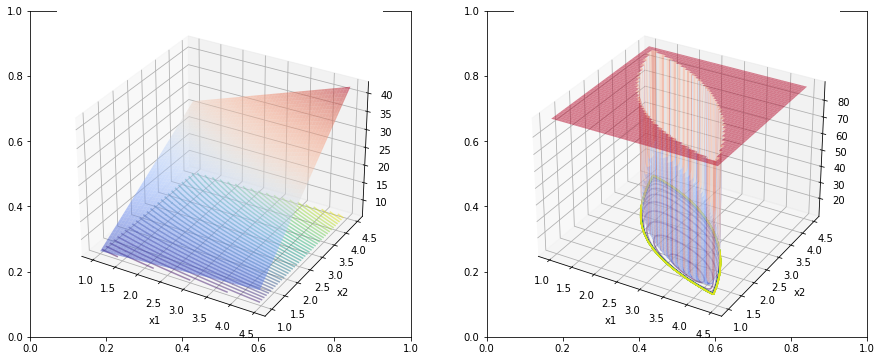

In [6]:
import matplotlib.cm as cm
x = np.arange(1,np.sqrt(20),0.01)
x = np.array(np.meshgrid(x,x))

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax1.set_xlabel('x1')
ax1.set_ylabel('x2')
y = f(x)
ax1.plot_surface(x[0], x[1], y, alpha=0.5, cmap='coolwarm')
ax1.contour(x[0], x[1], y, zdir='z', offset=y.min(), levels=50, alpha=0.5)

ax2 = fig.add_subplot(1, 2, 2, projection='3d')
ax2.set_xlabel('x1')
ax2.set_ylabel('x2')
t = 0.5
y = f(x) + (1/t)*barrier(constr, x)
y[np.isnan(y)] = y[~np.isnan(y)].max()
ax2.set_zlim(y[~np.isnan(y)].min()-1, y[~np.isnan(y)].max())
ax2.plot_surface(x[0], x[1], y, alpha=0.5, cmap='coolwarm')
ax2.contour(x[0], x[1], y, zdir='z', offset=y.min(), levels=50, alpha=0.5)


In [7]:
def gradient(f, x, epsilon=1e-7, y=None):
    """ numerically find gradients. 
    x: shape=[n] """    
    grad = np.zeros_like(x, dtype=float)
    for i in range(len(x)):
        h = np.zeros_like(x, dtype=float)
        h[i] = epsilon
        if y is None:
            grad[i] = (f(x + h) - f(x - h)) / (2 * h[i])
        else:
            grad[i] = (f(x + h, y) - f(x - h, y)) / (2 * h[i])
    return grad

def grad_decent(f, init, step, y=None, lr=0.001, history=False):
    x = init
    memo = [x]
    for i in range(step):
        if y is None:
            grad = gradient(f, x)        
        else:
            grad = gradient(f, x, y=y)                       
        x = x - lr * grad                
        if history: memo.append(x)    
    if not history: return x    
    return x, np.array(list(zip(*memo)))

def jacobian(f, m, x, y=None, h=1e-7, verbose=False):
    """ numerically find jacobian, constraint: m > 1
    f: call instance with shape=[m]
    x: shape=[n] """    
    n = len(x)
    jaco = np.zeros(shape=(m, n), dtype=float)
    for i in range(m):
        if y is None:
            jaco[i, :] = gradient(lambda e: f(e)[i], x)    
        else:
            jaco[i, :] = gradient(lambda e, l: f(e, l)[i], x, y=y)    
    if np.linalg.det(jaco) == 0: 
        if verbose: print('jacobian is singular, use pseudo-inverse')    
    return jaco

def raphson(f, m, init, nu=None, epsilon=1e-7, verbose=True, history=False, max_iter=1000):
    """ Newton Raphson Method.
    f: function 
    m: the number of output dimension
    init: np.array, with dimension n """
        
    n = len(init)
    if nu is None: 
        hessian = lambda f, n, x: jacobian(lambda e: gradient(f, e), n, x=x)
    else:
        hessian = lambda f, n, x, y: jacobian(lambda x, nu: gradient(f, x, y=nu), n, x=x, y=y)
    
    x = deepcopy(init)
    bound = 1e-7
    memo = [x]
    while max_iter:
        if nu is None: 
            H_inv = np.linalg.inv(hessian(f, n=len(x), x=x))
            update = np.matmul(H_inv, gradient(f, x))
        else:
            H_inv = np.linalg.inv(hessian(f, n=len(x), x=x, y=nu))
            update = np.matmul(H_inv, gradient(f, x, y=nu))
        x = x - update
        if bound > sum(np.abs(update)):
            break
        if verbose: print("x={}, update={}".format(x, sum(np.abs(update))))
        if history: memo.append(x)
        max_iter -= 1
    if not history: return x
    return x, np.array(list(zip(*memo)))


def Ipopt(f, ieconstr, init, m, d_init=None, econstr=None, eps=1e-6, inner_step=100, mu=2, t=0.01, outter_step=10, verbose=True, inner_lr=0.01):    
    t_values = []
    central_path = [init]
    ans = 0
    p_ans = 0
    if econstr is not None:
        d_central_path = [d_init]        
        
    for i in range(outter_step):
        if m/t <= eps:
            print("finish!")
            break
        if econstr is None:
            objective = lambda e: t * f(e) + barrier(ieconstr, e)
            ans, history = raphson(objective, m=m, init=central_path[-1], verbose=False, history=True, max_iter=inner_step)
        else:            
#             lagrange = lambda e,nu: t * f(e) + barrier(ieconstr, e) + np.dot(nu.T, econstr(e))
    
#             dual_function = lambda e: lagrange(grad_decent(lagrange, init=central_path[-1], y=e, step=inner_step, lr=0.01, history=False), e)
#             dual_function = lambda e: lagrange(raphson(lagrange, m=m, init=central_path[-1], nu=e, verbose=False, history=False, max_iter=inner_step), e)        
#             objective = lambda e: -dual_function(e)
            
#             def objective(nu):
#                 nonlocal p_ans
#                 p_ans = grad_decent(lagrange, init=p_ans, y=nu, step=inner_step, lr=0.01, history=False)                            
#                 p_ans = grad_decent(lagrange, init=central_path[0], y=nu, step=inner_step, lr=0.01, history=False)                
#                 p_ans = raphson(lagrange, m=m, init=central_path[-1], nu=nu, verbose=False, history=False, max_iter=inner_step) # it does not work in sigular case 
#                 if True in np.isnan(p_ans):
#                     p_ans = central_path[0]
#                     return - lagrange(p_ans, nu)
#                 central_path.append(p_ans)
#                 return - lagrange(p_ans, nu)        

#             ans, history = raphson(objective, m=m, init=d_central_path[-1], verbose=False, history=True, max_iter=inner_step) # it does not work in sigular case 
#             ans, history = grad_decent(objective, init=d_central_path[-1], step=inner_step, lr=0.01, history=True)
#             ans = np.clip(ans, 0.1, 1000)
                                    
            lagrange = lambda e,nu: t * f(e) + barrier(ieconstr, e) + t * np.dot(nu.T, econstr(e))               
            p_ans = grad_decent(lagrange, init=central_path[-1], y=d_central_path[-1], step=inner_step, lr=inner_lr, history=False) 
#             p_ans = raphson(lagrange, m=m, init=central_path[-1], nu=d_central_path[-1], verbose=False, history=False, max_iter=inner_step)
            if True in np.isnan(p_ans):
                print("central point is nan so update is rejected into: {}".format(central_path[-1]))
                break
            else:
                central_path.append(p_ans)
                
            dual = lambda e: -lagrange(p_ans, e)
            ans = grad_decent(dual, init=d_central_path[-1], step=inner_step, lr=inner_lr, history=False)
#             ans = raphson(dual, m=m, init=d_central_path[-1], verbose=False, history=True, max_iter=inner_step)
#             ans = np.clip(ans, 0.01, 1000)
            
        if verbose:            
            print("t: {}, ans: {}".format(t, ans))
            if econstr is not None:
                print("t: {}, p_ans: {}".format(t, p_ans))
            
        if econstr is None:
            if True in np.isnan(ans):  
                print("central point is nan so update is rejected into: {}".format(central_path[-1]))
                break           
            else:
                central_path.append(ans)
        else:
            if True in np.isnan(ans):
                print("d_central point is nan so update is rejected into: {}".format(d_central_path[-1]))
                break
            else:
                d_central_path.append(ans)
            
        t_values.append(t)    
        t = mu * t
            
    return ans, np.array(central_path), np.array(t_values)

t: 0.01, ans: [2.76 2.7 ]
t: 0.015, ans: [2.77 2.67]
t: 0.0225, ans: [2.79 2.64]
t: 0.03375, ans: [2.81 2.59]
t: 0.050625, ans: [2.85 2.52]
t: 0.0759375, ans: [2.91 2.41]
t: 0.11390625000000001, ans: [2.99 2.27]
t: 0.17085937500000004, ans: [3.11 2.09]
t: 0.25628906250000005, ans: [3.26 1.9 ]
t: 0.3844335937500001, ans: [3.42 1.72]
t: 0.5766503906250001, ans: [3.59 1.57]
t: 0.8649755859375001, ans: [3.75 1.45]
t: 1.2974633789062502, ans: [3.89 1.37]
t: 1.9461950683593754, ans: [4.01 1.3 ]
t: 2.919292602539063, ans: [4.09 1.26]
t: 4.378938903808595, ans: [4.16 1.23]
t: 6.568408355712892, ans: [4.21 1.2 ]
t: 9.852612533569339, ans: [4.25 1.19]
t: 14.778918800354008, ans: [4.27 1.18]
t: 22.168378200531013, ans: [4.29 1.17]
t: 33.25256730079652, ans: [4.3  1.17]
t: 49.87885095119478, ans: [4.3  1.16]
t: 74.81827642679217, ans: [4.31 1.16]
finish!


/home/swyoo/anaconda3/envs/cvxpy/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log
  


Text(0, 0.5, 'f - f*')

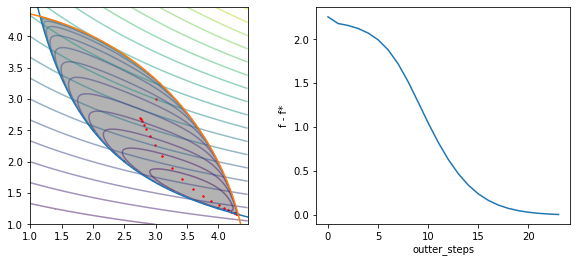

In [8]:
init = np.array([3,3])
ans, c_path, ts = Ipopt(f=f, ieconstr=constr, init=init, m=1, outter_step=100, inner_step=100, 
                        mu=1.5, t=0.01, eps=0.01, verbose=True)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
fig.clf()
ax1 = fig.add_subplot(1, 2, 1)

x = np.arange(1,np.sqrt(20),0.01)
ax1.set_xlim(x.min(),x.max())
ax1.set_ylim(x.min(),x.max())
ax1.plot(x,k(x)[0])
ax1.plot(x,k(x)[1])

x = np.array(np.meshgrid(x,x))
ax1.imshow(g(x).astype(int),
           extent=(x[0].min(),x[0].max(),x[1].min(),x[1].max()),
           origin="lower", cmap="Greys", alpha = 0.3)
ax1.contour(x[0],x[1],f(x), levels=20, alpha=0.5)
ax1.scatter(c_path[:,0], c_path[:,1],s=2,color='r')
plt.contour(x[0],x[1],f(x) + barrier(constr, x), levels=30, alpha=0.5)

ax2 = fig.add_subplot(1, 2, 2)
order = list(range(len(c_path)))
gaps = [np.linalg.norm(p) for p in c_path - ans]
ax2.plot(order, gaps)
ax2.set_xlabel('outter_steps')
ax2.set_ylabel('f - f*')

t: 0.01, ans: [10.95 -2.19]
t: 0.015, ans: [ 9.3  -1.86]
t: 0.0225, ans: [ 7.98 -1.6 ]
t: 0.03375, ans: [ 6.91 -1.38]
t: 0.050625, ans: [ 6.05 -1.21]
t: 0.0759375, ans: [ 5.37 -1.07]
t: 0.11390625000000001, ans: [ 4.84 -0.97]
t: 0.17085937500000004, ans: [ 4.43 -0.89]
t: 0.25628906250000005, ans: [ 4.12 -0.82]
t: 0.3844335937500001, ans: [ 3.89 -0.78]
t: 0.5766503906250001, ans: [ 3.72 -0.74]
t: 0.8649755859375001, ans: [ 3.6  -0.72]
t: 1.2974633789062502, ans: [ 3.52 -0.7 ]
t: 1.9461950683593754, ans: [ 3.46 -0.69]
t: 2.919292602539063, ans: [ 3.42 -0.68]
t: 4.378938903808595, ans: [ 3.39 -0.68]
t: 6.568408355712892, ans: [ 3.37 -0.67]
t: 9.852612533569339, ans: [ 3.36 -0.67]
t: 14.778918800354008, ans: [ 3.35 -0.67]
t: 22.168378200531013, ans: [ 3.34 -0.67]
t: 33.25256730079652, ans: [ 3.34 -0.67]
t: 49.87885095119478, ans: [ 3.34 -0.67]
t: 74.81827642679217, ans: [ 3.34 -0.67]
t: 112.22741464018824, ans: [ 3.34 -0.67]
t: 168.34112196028235, ans: [ 3.33 -0.67]
finish!


Text(0, 0.5, 'f - f*')

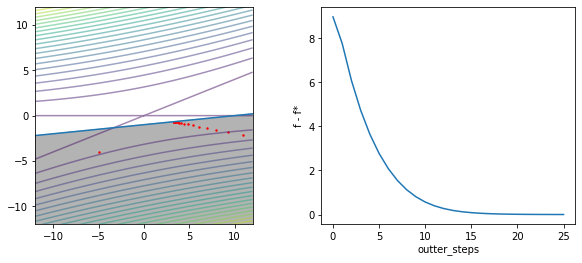

In [9]:
def f(x):
    return x[1]**2 - 2*x[0]*x[1] + 4*x[1]**2
def constr(x):    
    f1 = -0.1*x[0] + x[1] + 1    
    return np.array([f1])
def g(x):    
    return -0.1*x[0] + x[1] + 1 <= 0
def k(x):
    y = 0.1*x - 1
    return y

init = np.array([-5,-4])
ans, c_path, ts = Ipopt(f=f, ieconstr=constr, init=init, m=2, outter_step=100, inner_step=100, 
                        mu=1.5, t=0.01, eps=0.01, verbose=True)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
fig.clf()
ax1 = fig.add_subplot(1, 2, 1)
ax1.cla()
x = np.arange(-12,12,0.01)
ax1.set_xlim(x.min(),x.max())
ax1.set_ylim(x.min(),x.max())
ax1.plot(x,k(x))

x = np.array(np.meshgrid(x,x))
ax1.imshow(g(x).astype(int),
           extent=(x[0].min(),x[0].max(),x[1].min(),x[1].max()),
           origin="lower", cmap="Greys", alpha = 0.3)
ax1.contour(x[0],x[1],f(x), levels=20, alpha=0.5)
ax1.scatter(c_path[:,0], c_path[:,1],s=2,color='r')

ax2 = fig.add_subplot(1, 2, 2)
ax2.cla()
order = list(range(len(c_path)))
gaps = [np.linalg.norm(p) for p in c_path - ans]
ax2.plot(order, gaps)
ax2.set_xlabel('outter_steps')
ax2.set_ylabel('f - f*')


The optimal cost is 33.999999999999986
The optimal point is [2.67 3.67]
t: 0.001, ans: [1.]
t: 0.001, p_ans: [1.55 2.09]
t: 0.0011, ans: [1.]
t: 0.0011, p_ans: [1.59 2.16]
t: 0.0012100000000000001, ans: [0.99]
t: 0.0012100000000000001, p_ans: [1.62 2.23]
t: 0.0013310000000000002, ans: [0.99]
t: 0.0013310000000000002, p_ans: [1.63 2.29]
t: 0.0014641000000000003, ans: [0.99]
t: 0.0014641000000000003, p_ans: [1.64 2.34]
t: 0.0016105100000000005, ans: [0.99]
t: 0.0016105100000000005, p_ans: [1.64 2.38]
t: 0.0017715610000000007, ans: [0.99]
t: 0.0017715610000000007, p_ans: [1.64 2.42]
t: 0.0019487171000000009, ans: [0.98]
t: 0.0019487171000000009, p_ans: [1.64 2.45]
t: 0.002143588810000001, ans: [0.98]
t: 0.002143588810000001, p_ans: [1.63 2.48]
t: 0.0023579476910000016, ans: [0.98]
t: 0.0023579476910000016, p_ans: [1.63 2.51]
t: 0.002593742460100002, ans: [0.97]
t: 0.002593742460100002, p_ans: [1.62 2.53]
t: 0.0028531167061100022, ans: [0.97]
t: 0.0028531167061100022, p_ans: [1.62 2.55]
t

/home/swyoo/anaconda3/envs/cvxpy/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log
  


central point is nan so update is rejected into: [2.71 3.55]
answer is [2.71 3.55]


/home/swyoo/anaconda3/envs/cvxpy/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  
/home/swyoo/anaconda3/envs/cvxpy/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log
  


Text(0, 0.5, 'f - f*')

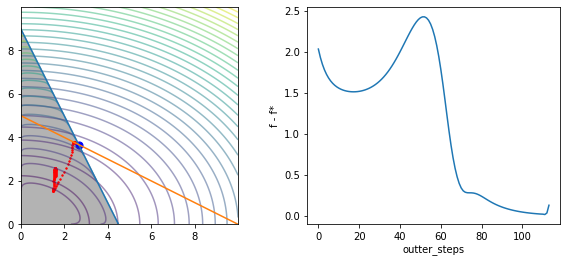

In [10]:
def f(x):    
    return (x[0]**2) + 2*(x[1]**2)

def ieconstr(x):    
    f1 = 2*x[0] + x[1] - 9
    f2 = -x[0]
    f3 = -x[1]
    return np.array([f1,f2,f3])

def econstr(x):
    f1 = x[0] + 2*x[1] - 10
    return np.array([f1])

def g(x):
    g1,g2,g3 = ieconstr(x)        
    return (g1 <= 0) & (g2 <= 0) & (g3 <= 0)

def k(x):    
    k1 = 9 - 2 * x
    k2 = 5 - x / 2    
    return np.array([k1,k2])

import cvxpy as cp
x = cp.Variable(shape=(2))
cost = f(x)

constr = [2*x[0] +x[1]<= 9]
constr += [x[0] + 2 * x[1] == 10]
constr += [x[0] >= 0]
constr += [x[1] >= 0]
prob = cp.Problem(cp.Minimize(cost), constraints=constr)
prob.solve()

# Print result.
print("\nThe optimal cost is", prob.value)
optimal_point = x.value
print("The optimal point is", optimal_point)

init = np.array([1.5, 2])
d_init = np.array([1])
ans, c_path, ts = Ipopt(f=f, ieconstr=ieconstr, init=init, d_init=d_init, m=1,
                        econstr=econstr, outter_step=300, inner_step=4000, 
                        mu=1.1, t=0.001, eps=0.01, verbose=True, inner_lr=0.0001)

print("answer is {}".format(c_path[-1]))

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
fig.clf()
ax1 = fig.add_subplot(1, 2, 1)
ax1.cla()
x = np.arange(0,10,0.01)
ax1.set_xlim(x.min(),x.max())
ax1.set_ylim(x.min(),x.max())
ax1.plot(x,k(x)[0])
ax1.plot(x,k(x)[1])

x = np.array(np.meshgrid(x,x))
ax1.imshow(g(x).astype(int),
           extent=(x[0].min(),x[0].max(),x[1].min(),x[1].max()),
           origin="lower", cmap="Greys", alpha = 0.3)
ax1.contour(x[0],x[1],f(x), levels=30, alpha=0.5)
t = 1
ax1.contour(x[0],x[1], (t  * f(x) + barrier(ieconstr, x) + t * d_init * econstr(x))[0] , levels=20, alpha=0.5)
ax1.scatter(c_path[:,0], c_path[:,1], s=2, color='r')
ax1.scatter(optimal_point[0], optimal_point[1], s=50, color='b')

ax2 = fig.add_subplot(1, 2, 2)
ax2.cla()
order = list(range(len(c_path)))
gaps = [np.linalg.norm(p) for p in c_path - optimal_point]
ax2.plot(order, gaps)
ax2.set_xlabel('outter_steps')
ax2.set_ylabel('f - f*')

# reference
[ipopt](http://cepac.cheme.cmu.edu/pasilectures/biegler/ipopt.pdf)  
[c++ code](https://github.com/coin-or/Ipopt)  
[cvxpy](https://www.cvxpy.org/)  